In [ ]:
# Connect to Google Drive
from google.colab import drive,files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change Directory
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 49.1 MB/s eta 0:00:00


In [ ]:
%cd ML4Earth_PhysicAware

/content/drive/MyDrive/ML4Earth_PhysicAware


In [ ]:
%cd 'ML4Earth-Hackathon-2023/Code/FNO_Flood'

/content/drive/MyDrive/ML4Earth_PhysicAware/ML4Earth-Hackathon-2023/Code/FNO_Flood


In [ ]:
import torch
import h5py
torch.cuda.is_available()

True

In [ ]:
import argparse
import numpy as np
import random
import torch
from systems_pbc import *
import torch.backends.cudnn as cudnn
from utils import *
from visualize import *
import matplotlib.pyplot as plt
from models import FNN3d
from train_utils import Adam
from tqdm import tqdm
from train_utils.losses import GeoPC_loss
import matplotlib.image as pm
import torch.nn as nn
import tifffile
from data import utils
import scipy.ndimage
import boundary
from PIL import Image
import train_utils.tensorboard as tb
from AWL import AutomaticWeightedLoss
import torch.nn.functional as F
from scipy import interpolate
from skimage.transform import resize
from train_utils.losses import *
from torch.utils.data import DataLoader
import imageio
import io
import os

In [ ]:
# load data
# valset= dataset.train_data(train=False)

In [ ]:
# # Create or open an HDF5 file for saving the data
# file_name = 'Validation_data.h5'
# with h5py.File(file_name, 'w') as hdf_file:
#     # Save the initial 'elevation' and 'velocity' datasets
#     hdf_file.create_dataset('data_input', data=valset.data_input.numpy())
#     hdf_file.create_dataset('gt_h', data=valset.gt_h.numpy())
#     hdf_file.create_dataset('data_z', data=valset.data_z.numpy())
#     hdf_file.create_dataset('data_Rain', data=valset.data_Rain.numpy())
#     hdf_file.create_dataset('data_Manning', data=valset.data_Manning.numpy())
#     hdf_file.create_dataset('data_mm', data=valset.data_mm.numpy())

In [ ]:
import h5py
import torch
from torch.utils.data import Dataset, DataLoader

class LoadDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path

        # Open the HDF5 file
        with h5py.File(file_path, 'r') as hdf_file:
           self.data_input = torch.tensor(hdf_file['data_input'])
           self.gt_h = torch.tensor(hdf_file['gt_h'])
           self.data_z = torch.tensor(hdf_file['data_z'])
           self.data_Rain = torch.tensor(hdf_file['data_Rain'])
           self.data_Manning = torch.tensor(hdf_file['data_Manning'])
           self.data_mm = torch.tensor(hdf_file['data_mm'])

    def __getitem__(self, idx):
        return self.data_input[idx], self.gt_h[idx], self.data_z[idx], self.data_Rain[idx], self.data_Manning[idx], self.data_mm[idx]

    def __len__(self, ):
        return self.data_input.shape[0]

In [ ]:
modes1 = [8, 8, 12, 12]
modes2 = [8, 8, 12, 12]
modes3 = [8, 8, 8, 8]
fc_dim = 128
layers = [16, 24, 24, 24, 32, 32]
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)
else:
    device = torch.device('cpu')
    print(device)

# gpu_ids = [0]
# output_device = gpu_ids[0]
lr = 0.001
milestones = [500, 1000, 2000, 3000, 4000, 5000]
gamma = 0.5
train_path = f'''../../../Loaded Data/Training_data.h5'''
valid_path = f'''../../../Loaded Data/Validation_data.h5'''

cuda


In [ ]:
trainset = LoadDataset(train_path)
train_loader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)

<ipython-input-8-33322df5bcd1>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.data_input = torch.tensor(hdf_file['data_input'])


In [ ]:
valset = LoadDataset(valid_path)
val_loader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=2)

##Model

In [ ]:
import torch.nn as nn
from models.basics import SpectralConv3d
from models.utils import add_padding, remove_padding, _get_act

class MyLinearRegressionSW(nn.Module):
    def __init__(self,
                 modes1, modes2, modes3,
                 width=16,
                 fc_dim=128,
                 layers=None,
                 in_dim=8, out_dim=1,  # Change out_dim to 1 for linear regression
                 act='gelu',
                 pad_ratio=[0., 0.]):
        '''
        Args:
            modes1: list of int, first dimension maximal modes for each layer
            modes2: list of int, second dimension maximal modes for each layer
            modes3: list of int, third dimension maximal modes for each layer
            layers: list of int, channels for each layer
            fc_dim: dimension of fully connected layers
            in_dim: int, input dimension
            out_dim: int, output dimension (change to 1 for linear regression)
            act: {tanh, gelu, relu, leaky_relu}, activation function
            pad_ratio: the ratio of the extended domain
        '''
        super(MyLinearRegressionSW, self).__init__()

        if isinstance(pad_ratio, float):
            pad_ratio = [pad_ratio, pad_ratio]
        else:
            assert len(pad_ratio) == 2, 'Cannot add padding in more than 2 directions.'


        self.pad_ratio = pad_ratio
        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.pad_ratio = pad_ratio

        if layers is None:
            self.layers = [width] * 4
        else:
            self.layers = layers
        self.fc0 = nn.Linear(in_dim, layers[0])

        self.sp_convs = nn.ModuleList([SpectralConv3d(
            in_size, out_size, mode1_num, mode2_num, mode3_num)
            for in_size, out_size, mode1_num, mode2_num, mode3_num
            in zip(self.layers, self.layers[1:], self.modes1, self.modes2, self.modes3)])

        self.ws = nn.ModuleList([nn.Conv1d(in_size, out_size, 1)
                                 for in_size, out_size in zip(self.layers, self.layers[1:])])


        self.fc1 = nn.Linear(layers[-1], fc_dim)
        self.fc2 = nn.Linear(fc_dim, out_dim)  # Change out_dim to 1 for linear regression
        self.act = _get_act(act)


    def forward(self, x):
        '''
        Args:
            x: (batchsize, x_grid, y_grid, t_grid, 3)

       Returns:
            u: (batchsize, x_grid, y_grid, t_grid, 1)  # Change the last dimension to 1
        '''
        size_z = x.shape[-2]
        if max(self.pad_ratio) > 0:
            num_pad = [round(size_z * i) for i in self.pad_ratio]
        else:
            num_pad = [0., 0.]
        length = len(self.ws)
        batchsize = x.shape[0]

        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        x = add_padding(x, num_pad=num_pad)
        size_x, size_y, size_z = x.shape[-3], x.shape[-2], x.shape[-1]

        for i, (speconv, w) in enumerate(zip(self.sp_convs, self.ws)):
            x1 = speconv(x)
            x2 = w(x.view(batchsize, self.layers[i], -1)).view(batchsize, self.layers[i+1], size_x, size_y, size_z)
            x = x1 + x2
            if i != length - 1:
                x = self.act(x)
        x = remove_padding(x, num_pad=num_pad)
        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)  # Change the last fully connected layer to predict a scalar
        x = self.act(x)
        return x

In [ ]:
model = MyLinearRegressionSW(modes1=modes1, modes2=modes2, modes3=modes3, fc_dim=fc_dim,
                  layers=layers).to(device)
    # model = nn.DataParallel(model, device_ids=gpu_ids, output_device=output_device)
optimizer = Adam(model.parameters(), betas=(0.9, 0.999), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

model.train()
    # input data
epochs = 10
pbar = range(epochs)
pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.05)
model.train()


  0%|          | 0/10 [00:00<?, ?it/s]

MyLinearRegressionSW(
  (fc0): Linear(in_features=8, out_features=16, bias=True)
  (sp_convs): ModuleList(
    (0-3): 4 x SpectralConv3d()
  )
  (ws): ModuleList(
    (0): Conv1d(16, 24, kernel_size=(1,), stride=(1,))
    (1-2): 2 x Conv1d(24, 24, kernel_size=(1,), stride=(1,))
    (3): Conv1d(24, 32, kernel_size=(1,), stride=(1,))
    (4): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 9 loss_d: 1.02774 loss_c: 1.02768 :   0%|          | 0/10 [17:50<?, ?it/s]


In [ ]:
def eval(model, log_dir):
    model.eval()
    key = 0

    for i, data in enumerate(val_loader):
        with torch.no_grad():
            out = model(input_to_nn)
        h = out[:, :, :, :, :1]
        h, h01 = F.threshold(h, threshold=0, value=0), F.threshold(h, threshold=0.1, value=0)
        # h_gt, qx_gt, qy_gt = data(i)
        h, h01 = torch.squeeze(h), torch.squeeze(h01)
        h, h01 = h.permute(2, 0, 1), h01.permute(2, 0, 1)
        h_g = torch.squeeze(gt_h).permute(2,0,1)
        h_p = h.detach().cpu().numpy()
        # h_p = h_p.reshape(-1, 1)
        # u_p = u.detach().cpu().numpy()
        # u_p = u_p.reshape(-1, 1)
        # v_p = v.detach().cpu().numpy()
        # v_p = v_p.reshape(-1, 1)

        h_gt = h_g.detach().cpu().numpy()

        print('h_gt', h_gt.shape)
        print('h_p', h_p.shape)
        # MSE error
        error_h_abs = np.mean(np.abs(h_gt - h_p))

        print('error_h_abs',error_h_abs)

In [ ]:
for e in range(epochs):
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            input_data, gt_h, z, Rain, Manning, mm = data
            input_data = torch.squeeze(input_data)
            gt_h =gt_h.permute(2, 3, 1, 0)
            z = z.permute(1, 2, 0).unsqueeze(2).expand(-1, -1, 16, -1)
            Rain = Rain.squeeze().permute(1,2,0).unsqueeze(3).expand(-1, -1, -1, 1)
            Manning =Manning.squeeze().unsqueeze(2).unsqueeze(3).expand(-1, -1, 16,1)
            concatenated_data = torch.cat((input_data, gt_h, z, Rain, Manning), dim=3)
            concatenated_data = concatenated_data.unsqueeze(0)
            input_to_nn = concatenated_data.to(device)
            # print(input_data.shape)
            with torch.no_grad():
              out = model(input_to_nn)
            h, h01 = F.threshold(out, threshold=0, value=0), F.threshold(out, threshold=0.1, value=0)
            h, h01 = torch.squeeze(h), torch.squeeze(h01)
            # h, h01 = h.permute(2, 0, 1), h01.permute(2, 0, 1)
            h_pred = h.detach().cpu().numpy()
            h01_pred = h01.detach().cpu().numpy()

        #     # print(out.shape)
        #     # boundary
            output = out.permute(0, 3, 1, 2, 4)
            outputH = output[:, :, :, :, 0].clone()
            loss_d, loss_c = GeoPC_loss(input_data, outputH, data_condition, init_condition)
            total_loss = loss_c + loss_d
            # total_loss.backward(retain_graph=False)
            optimizer.step()

            total_loss = total_loss.item()
            scheduler.step()
            pbar.set_description(
                (
                    f'Epoch {e} '
                    f'loss_d: {loss_d:.5f} '
                    f'loss_c: {loss_c:.5f} '
                )
            )
            # loss
            tb.log_scalars(e, write_hparams=True,
                           loss_d=loss_d)
            if e%500 == 0:
                log_dir = './FNO/Results/'
                eval(model, log_dir)

                state_dict = model.state_dict()
                torch.save({'epoch': e, 'state_dict': state_dict},
                          log_dir + f'pretrain/checkpoint_%d.pth'%(e))
            torch.cuda.empty_cache()
print('Done')


Epoch 0 loss_d: 1.01580 loss_c: 1.01578 :   0%|          | 0/10 [00:07<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.124688864
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12


Epoch 0 loss_d: 1.01612 loss_c: 1.01611 :   0%|          | 0/10 [00:12<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10780273
h_gt (16


Epoch 0 loss_d: 1.01596 loss_c: 1.01595 :   0%|          | 0/10 [00:17<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11229163
h_gt (16


Epoch 0 loss_d: 1.01586 loss_c: 1.01584 :   0%|          | 0/10 [00:21<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12729649
h_gt (16


Epoch 0 loss_d: 1.01612 loss_c: 1.01611 :   0%|          | 0/10 [00:26<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10761259
h_gt (16


Epoch 0 loss_d: 1.01581 loss_c: 1.01580 :   0%|          | 0/10 [00:31<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13006875
h_gt (16


Epoch 0 loss_d: 1.01609 loss_c: 1.01608 :   0%|          | 0/10 [00:35<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.108953945
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10


Epoch 0 loss_d: 1.01585 loss_c: 1.01584 :   0%|          | 0/10 [00:40<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11944536
h_gt (16


Epoch 0 loss_d: 1.01581 loss_c: 1.01580 :   0%|          | 0/10 [00:45<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12892552
h_gt (16


Epoch 0 loss_d: 1.01609 loss_c: 1.01608 :   0%|          | 0/10 [00:49<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1095067
h_gt (16, 810, 441)
h_p 


Epoch 0 loss_d: 1.01581 loss_c: 1.01579 :   0%|          | 0/10 [00:54<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.120496646
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12


Epoch 0 loss_d: 1.01596 loss_c: 1.01594 :   0%|          | 0/10 [00:59<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11271778
h_gt (16


Epoch 0 loss_d: 1.01581 loss_c: 1.01580 :   0%|          | 0/10 [01:03<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12949663
h_gt (16


Epoch 0 loss_d: 1.01614 loss_c: 1.01611 :   0%|          | 0/10 [01:08<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107985586
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10


Epoch 0 loss_d: 1.01608 loss_c: 1.01610 :   0%|          | 0/10 [01:12<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10576109
h_gt (16


Epoch 0 loss_d: 1.01596 loss_c: 1.01595 :   0%|          | 0/10 [01:17<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11194454
h_gt (16


Epoch 0 loss_d: 1.01597 loss_c: 1.01595 :   0%|          | 0/10 [01:22<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109981164
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10


Epoch 0 loss_d: 1.01614 loss_c: 1.01613 :   0%|          | 0/10 [01:26<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10848104
h_gt (16


Epoch 0 loss_d: 1.01580 loss_c: 1.01578 :   0%|          | 0/10 [01:31<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12311348
h_gt (16


Epoch 0 loss_d: 1.01595 loss_c: 1.01594 :   0%|          | 0/10 [01:36<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11360729
h_gt (16


Epoch 0 loss_d: 1.01604 loss_c: 1.01603 :   0%|          | 0/10 [01:40<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10617682
h_gt (16


Epoch 0 loss_d: 1.01581 loss_c: 1.01579 :   0%|          | 0/10 [01:45<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1215439
h_gt (16, 810, 441)
h_p 


Epoch 0 loss_d: 1.01580 loss_c: 1.01578 :   0%|          | 0/10 [01:50<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12521604
h_gt (16


Epoch 0 loss_d: 1.01585 loss_c: 1.01584 :   0%|          | 0/10 [01:54<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11837143
h_gt (16


Epoch 0 loss_d: 1.01586 loss_c: 1.01584 :   0%|          | 0/10 [01:59<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12678078
h_gt (16


Epoch 0 loss_d: 1.01582 loss_c: 1.01584 :   0%|          | 0/10 [02:04<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12779967
h_gt (16


Epoch 0 loss_d: 1.01597 loss_c: 1.01595 :   0%|          | 0/10 [02:08<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11058573
h_gt (16


Epoch 0 loss_d: 1.01580 loss_c: 1.01578 :   0%|          | 0/10 [02:13<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.123638034
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12


Epoch 0 loss_d: 1.01614 loss_c: 1.01613 :   0%|          | 0/10 [02:18<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10822794
h_gt (16


Epoch 0 loss_d: 1.01593 loss_c: 1.01591 :   0%|          | 0/10 [02:22<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.116179995
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11


Epoch 0 loss_d: 1.01585 loss_c: 1.01584 :   0%|          | 0/10 [02:27<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.118906915
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11


Epoch 0 loss_d: 1.01611 loss_c: 1.01609 :   0%|          | 0/10 [02:32<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.107228376
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10


Epoch 0 loss_d: 1.01593 loss_c: 1.01591 :   0%|          | 0/10 [02:36<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11402069
h_gt (16


Epoch 0 loss_d: 1.01593 loss_c: 1.01591 :   0%|          | 0/10 [02:41<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11455371
h_gt (16


Epoch 0 loss_d: 1.01610 loss_c: 1.01609 :   0%|          | 0/10 [02:46<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10702302
h_gt (16


Epoch 0 loss_d: 1.01589 loss_c: 1.01591 :   0%|          | 0/10 [02:50<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11783712
h_gt (16


Epoch 0 loss_d: 1.01593 loss_c: 1.01591 :   0%|          | 0/10 [02:55<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11728475
h_gt (16


Epoch 0 loss_d: 1.01593 loss_c: 1.01591 :   0%|          | 0/10 [03:00<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1150912
h_gt (16, 810, 441)
h_p 


Epoch 0 loss_d: 1.01593 loss_c: 1.01591 :   0%|          | 0/10 [03:04<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11673057
h_gt (16


Epoch 0 loss_d: 1.01583 loss_c: 1.01579 :   0%|          | 0/10 [03:09<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12574613
h_gt (16


Epoch 0 loss_d: 1.01596 loss_c: 1.01595 :   0%|          | 0/10 [03:14<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11089008
h_gt (16


Epoch 0 loss_d: 1.01597 loss_c: 1.01595 :   0%|          | 0/10 [03:18<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.110282324
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11


Epoch 0 loss_d: 1.01595 loss_c: 1.01594 :   0%|          | 0/10 [03:23<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11316113
h_gt (16


Epoch 0 loss_d: 1.01580 loss_c: 1.01578 :   0%|          | 0/10 [03:27<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12207182
h_gt (16


Epoch 0 loss_d: 1.01581 loss_c: 1.01580 :   0%|          | 0/10 [03:32<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12835634
h_gt (16


Epoch 0 loss_d: 1.01614 loss_c: 1.01613 :   0%|          | 0/10 [03:37<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10873474
h_gt (16


Epoch 0 loss_d: 1.01610 loss_c: 1.01609 :   0%|          | 0/10 [03:42<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.106819615
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10


Epoch 0 loss_d: 1.01596 loss_c: 1.01595 :   0%|          | 0/10 [03:46<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.111586496
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11


Epoch 0 loss_d: 1.01580 loss_c: 1.01578 :   0%|          | 0/10 [03:51<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12259163
h_gt (16


Epoch 0 loss_d: 1.01593 loss_c: 1.01591 :   0%|          | 0/10 [03:55<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.1156334
h_gt (16, 810, 441)
h_p 


Epoch 0 loss_d: 1.01586 loss_c: 1.01584 :   0%|          | 0/10 [04:00<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12626587
h_gt (16


Epoch 0 loss_d: 1.01605 loss_c: 1.01603 :   0%|          | 0/10 [04:05<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10639333
h_gt (16


Epoch 0 loss_d: 1.01606 loss_c: 1.01607 :   0%|          | 0/10 [04:09<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.109760806
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10


Epoch 0 loss_d: 1.01609 loss_c: 1.01608 :   0%|          | 0/10 [04:14<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10922984
h_gt (16


Epoch 0 loss_d: 1.01581 loss_c: 1.01579 :   0%|          | 0/10 [04:19<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12101887
h_gt (16


Epoch 0 loss_d: 1.01581 loss_c: 1.01580 :   0%|          | 0/10 [04:23<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13122681
h_gt (16


Epoch 0 loss_d: 1.01580 loss_c: 1.01578 :   0%|          | 0/10 [04:28<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.12416333
h_gt (16


Epoch 0 loss_d: 1.01604 loss_c: 1.01603 :   0%|          | 0/10 [04:33<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10596721
h_gt (16


Epoch 0 loss_d: 1.01596 loss_c: 1.01595 :   0%|          | 0/10 [04:37<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11123084
h_gt (16


Epoch 0 loss_d: 1.01612 loss_c: 1.01611 :   0%|          | 0/10 [04:42<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10742269
h_gt (16


Epoch 0 loss_d: 1.01581 loss_c: 1.01580 :   0%|          | 0/10 [04:47<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.13064691
h_gt (16


Epoch 0 loss_d: 1.01610 loss_c: 1.01609 :   0%|          | 0/10 [04:51<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.10661693
h_gt (16


Epoch 0 loss_d: 1.01582 loss_c: 1.01584 :   0%|          | 0/10 [04:56<?, ?it/s]

h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16, 810, 441)
h_p (16, 810, 441)
error_h_abs 0.11997767
h_gt (16


Epoch 9 loss_d: 1.01597 loss_c: 1.01595 :   0%|          | 0/10 [09:09<?, ?it/s]

Done


In [ ]:
_, h_true, _,_,_,_ = data

In [ ]:
import pandas as pd
h_pred = torch.flatten(out).tolist()
h_true = torch.flatten(gt_h).tolist()
result = pd.DataFrame({'h_true':h_true,'h_pred':h_pred})

In [ ]:
result_filter = result[(result['h_true']>0.1) & (result['h_pred']>0.1)]

In [ ]:
result_filter.to_csv('result_linear.csv')

In [ ]:
result_filter

,h_true,h_pred
4805136,0.777163,0.154152
4805137,0.776712,0.154153
4805138,0.776264,0.154153
4805139,0.775818,0.154153
4805140,0.775375,0.154153
4805141,0.774933,0.154153
4805142,0.774495,0.154153
4805143,0.774058,0.154153
4805144,0.773624,0.154153
4805145,0.773193,0.154153


In [ ]:
import plotly.express as px
fig = px.line(result_filter, title='H predicted vs. H true')
fig.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(result_filter['h_true'], result_filter['h_pred'])

mape = np.mean(np.abs((result_filter['h_true'].values - result_filter['h_pred'].values ) / result_filter['h_true'].values )) * 100

rmse = np.sqrt(mean_squared_error(result_filter['h_true'], result_filter['h_pred']))

In [ ]:
mae

0.19865005685572037

In [ ]:
mape

41.810973058786864

In [ ]:
torch.save(model.state_dict(), 'model_lr.pt')

In [ ]:
reshaped_array = h_pred[:,:,-1]

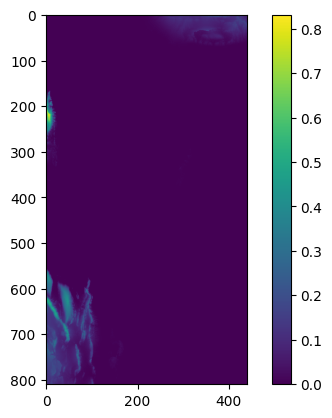

In [ ]:
# Plot the NumPy array as an image
plt.imshow(reshaped_array, cmap='viridis')  # You can choose a colormap (e.g., 'viridis', 'gray', 'jet', etc.)
plt.colorbar()  # Add a colorbar to the plot (optional)

# Show the image
plt.show()

In [ ]:
reshaped_array = gt_h.squeeze()[:,:,-1]

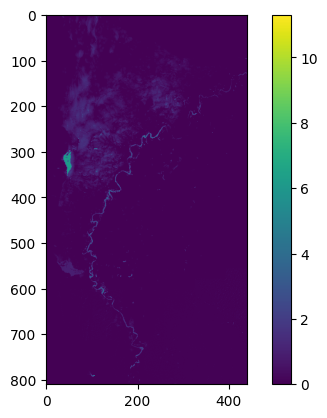

In [ ]:
# Plot the NumPy array as an image
plt.imshow(reshaped_array, cmap='viridis')  # You can choose a colormap (e.g., 'viridis', 'gray', 'jet', etc.)
plt.colorbar()  # Add a colorbar to the plot (optional)

# Show the image
plt.show()